In [57]:
from typing import NamedTuple, Sequence

import distrax
import flax.linen as nn
import gymnax
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState

from purejaxrl.wrappers import FlattenObservationWrapper, LogWrapper

# **_PPO Walkthrough_**


In [58]:
class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

### **_Initialization choices_**

- Dense layers use orthogonal initialization, which helps preserve the variance of the inputs through the layers during the forward pass and similarly helps preserve the variance of gradients during backprop.
- Orthogonal initialization often allows networks to converge faster
- The scaling factor $\sqrt 2$ at the start of the actor network comes from the "He initialization" strategy, which suggests scaling the weights by $\sqrt{(2/n)}$, where n is the number of inputs to a neuron. This scaling helps maintain a balance in the distribution of activations.
- The scaling factor $0.01$ applied to the output layer of the actor network helps encourages exploration as it makes actions probabilities closer initially.


In [59]:
class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        
        # actor
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        # creates a categorical distribution from actor logits
        pi = distrax.Categorical(logits=actor_mean)

        # critic
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )
        
        return pi, jnp.squeeze(critic, axis=-1) # converts shape [batch_size, 1] to [batch_size]

In [60]:
def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).n, activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                """
                Steps the environment across ``num_envs``.
                Returns the updated runner state and observation.
                """
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                actions = pi.sample(seed=_rng)
                log_prob = pi.log_prob(actions)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, actions, env_params)
                transition = Transition(
                    done, actions, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            # get the last value estimate to initialize gae computation
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                """
                Compute the generalized advantage estimation of a trajectory batch.

                ``GAE_t = delta_t + (lambda * gamma) * delta_{t+1} + (lambda * gamma)^2 * delta_{t+2}``
                """
                def _get_advantages(gae_and_next_value, transition):
                    """
                    Iteratively computes the GAE starting from the last transition.
                    Uses `lax.scan` to carry the current (`gae`, `next_value`) tuple
                    while iterating through transitions.
                    """
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    # td-error
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    # generalized advantage in recursive form
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae # (carry_over), collected results

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    # gae is computed backwards as the advantage at time t
                    # depends on the estimated advantages of future timesteps
                    reverse=True,
                    # unrolls the loop body of the scan operation 16 iterations at a time
				    # enables the 128 steps (default value) to be completed in 8 iterations
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                # Batching and Shuffling
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                # Mini-batch Updates
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            # Updating Training State and Metrics:
            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            # Debugging mode
            if config.get("DEBUG"):

                def callback(info):
                    return_values = info["returned_episode_returns"][
                        info["returned_episode"]
                    ]
                    timesteps = (
                        info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    )
                    for t in range(len(timesteps)):
                        print(
                            f"global step={timesteps[t]}, episodic return={return_values[t]}"
                        )

                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train

In [61]:
if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "Breakout-MinAtar",
        "ANNEAL_LR": True,
        "DEBUG": True,
    }
    rng = jax.random.PRNGKey(30)
    train_jit = jax.jit(make_train(config))
    out = train_jit(rng)

c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\purejaxrl-tsr51_H5-py3.10\lib\site-packages\jax\_src\ops\scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\purejaxrl-tsr51_H5-py3.10\lib\site-packages\jax\_src\ops\scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\purejaxrl-tsr51_H5-py3.10\lib\site-packages\jax\_src\ops\scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JA

global step=24, episodic return=0.0
global step=24, episodic return=0.0
global step=24, episodic return=0.0
global step=48, episodic return=0.0
global step=48, episodic return=0.0
global step=64, episodic return=1.0
global step=72, episodic return=0.0
global step=72, episodic return=0.0
global step=88, episodic return=1.0
global step=112, episodic return=0.0
global step=128, episodic return=1.0
global step=136, episodic return=1.0
global step=136, episodic return=1.0
global step=152, episodic return=0.0
global step=160, episodic return=0.0
global step=160, episodic return=0.0
global step=176, episodic return=0.0
global step=176, episodic return=1.0
global step=184, episodic return=0.0
global step=200, episodic return=0.0
global step=200, episodic return=0.0
global step=224, episodic return=1.0
global step=224, episodic return=0.0
global step=248, episodic return=1.0
global step=264, episodic return=1.0
global step=288, episodic return=1.0
global step=288, episodic return=1.0
global ste

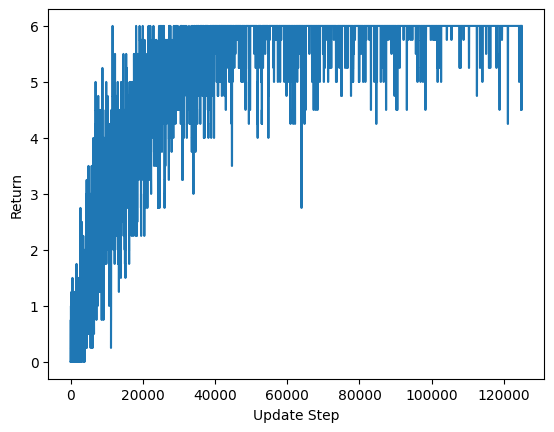

In [62]:
import matplotlib.pyplot as plt

plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

In [63]:
assert

SyntaxError: invalid syntax (2389114725.py, line 1)

In [ ]:
def linear_schedule(count):
    frac = (
        1.0
        - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
        / config["NUM_UPDATES"]
    )
    return config["LR"] * frac


config["NUM_UPDATES"] = (
    config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
)
config["MINIBATCH_SIZE"] = (
    config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
)
env, env_params = gymnax.make(config["ENV_NAME"])
env = FlattenObservationWrapper(env)
env = LogWrapper(env)


# INIT NETWORK
network = ActorCritic(env.action_space(env_params).n, activation=config["ACTIVATION"])
rng, _rng = jax.random.split(rng)
init_x = jnp.zeros(env.observation_space(env_params).shape)
network_params = network.init(_rng, init_x)
if config["ANNEAL_LR"]:
    tx = optax.chain(
        optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
        optax.adam(learning_rate=linear_schedule, eps=1e-5),
    )
else:
    tx = optax.chain(
        optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
        optax.adam(config["LR"], eps=1e-5),
    )
train_state = TrainState.create(
    apply_fn=network.apply,
    params=network_params,
    tx=tx,
)

# INIT ENV
rng, _rng = jax.random.split(rng)
reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)



# SELECT ACTION
rng, _rng = jax.random.split(rng)
pi, value = network.apply(train_state.params, obsv)
actions = pi.sample(seed=_rng) # 
log_prob = pi.log_prob(actions)

# STEP ENV
rng, _rng = jax.random.split(rng)
rng_step = jax.random.split(_rng, config["NUM_ENVS"])
obsv, env_state, reward, done, info = jax.vmap(
    env.step, in_axes=(0, 0, 0, None)
)(rng_step, env_state, actions, env_params)
transition = Transition(done, actions, value, reward, log_prob, obsv, info)
runner_state = (train_state, env_state, obsv, rng)


def _env_step(runner_state, unused):
    """
    Steps the environment across ``num_envs``.
    Returns the updated runner state and observation.
    """
    train_state, env_state, last_obs, rng = runner_state

    # SELECT ACTION
    rng, _rng = jax.random.split(rng)
    pi, value = network.apply(train_state.params, last_obs)
    action = pi.sample(seed=_rng)
    log_prob = pi.log_prob(action)

    # STEP ENV
    rng, _rng = jax.random.split(rng)
    rng_step = jax.random.split(_rng, config["NUM_ENVS"])
    obsv, env_state, reward, done, info = jax.vmap(
        env.step, in_axes=(0, 0, 0, None)
    )(rng_step, env_state, action, env_params)
    transition = Transition(done, action, value, reward, log_prob, last_obs, info)
    runner_state = (train_state, env_state, obsv, rng)
    return runner_state, transition

runner_state, traj_batch = jax.lax.scan(
    _env_step, (train_state, env_state, obsv, _rng), None, config["NUM_STEPS"]
)


c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\purejaxrl-tsr51_H5-py3.10\lib\site-packages\jax\_src\ops\scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\purejaxrl-tsr51_H5-py3.10\lib\site-packages\jax\_src\ops\scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [ ]:
# CALCULATE ADVANTAGE
train_state, env_state, last_obs, rng = runner_state
# get the last value estimate to initialize gae computation
_, last_val = network.apply(train_state.params, last_obs)

def _calculate_gae(traj_batch, last_val):
    """
    Compute the generalized advantage estimation of a trajectory batch.

    ``GAE_t = delta_t + (lambda * gamma) * delta_{t+1} + (lambda * gamma)^2 * delta_{t+2}``
    """
    def _get_advantages(gae_and_next_value, transition):
        gae, next_value = gae_and_next_value
        done, value, reward = (
            transition.done,
            transition.value,
            transition.reward,
        )
        # td-error
        delta = reward + config["GAMMA"] * next_value * (1 - done) - value
        # 
        gae = (
            delta
            + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
        )
        return (gae, value), gae

    _, advantages = jax.lax.scan(
        _get_advantages,
        (jnp.zeros_like(last_val), last_val),
        traj_batch,
        # gae is computed backwards as the advantage at time t
        # depends on the estimated advantages of future timesteps
        reverse=True,
        unroll=16,
    )
    return advantages, advantages + traj_batch.value

advantages, targets = _calculate_gae(traj_batch, last_val)

In [ ]:
runner_state

(TrainState(step=Array(0, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of ActorCritic(
     # attributes
     action_dim = 4
     activation = 'tanh'
 )>, params={'params': {'Dense_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[-3.85727937e-04, -3.46278995e-02,  2.74428539e-02, ...,
         -8.17569941e-02, -2.09074188e-02,  6.97153434e-02],
        [ 4.58751060e-02,  1.30935218e-02,  5.66706099e-02, ...,
          8.16995949e-02, -3.67662534e-02, -4.10039425e-02],
        [-1.31417615e-02,  5.56459390e-02,  3.91468182e-02, ...,
          7.04910681e-02,  7.32159615e-02,  2.57372316e-02],
        ...,
        [ 3.79669154e-03,  2.74528861e-02, -8.71988237e-02, ...,
         -2.2204

In [ ]:
update_state = (train_state, traj_batch, advantages, targets, rng)
train_state, traj_batch, advantages, targets, rng = update_state
rng, _rng = jax.random.split(rng)
# Batching and Shuffling
batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
assert (
    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
), "batch size must be equal to number of steps * number of envs"
permutation = jax.random.permutation(_rng, batch_size)
batch = (traj_batch, advantages, targets)
batch = jax.tree_util.tree_map(
    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
)
shuffled_batch = jax.tree_util.tree_map(
    lambda x: jnp.take(x, permutation, axis=0), batch
)
# Mini-batch Updates
minibatches = jax.tree_util.tree_map(
    lambda x: jnp.reshape(
        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
    ),
    shuffled_batch,
)

In [ ]:
def tree_shape(tree):
    return jax.tree_map(lambda x: x.shape, tree)

In [ ]:
tree_shape(minibatches)

(Transition(done=(4, 128), action=(4, 128), value=(4, 128), reward=(4, 128), log_prob=(4, 128), obs=(4, 128, 600), info={'discount': (4, 128), 'returned_episode': (4, 128), 'returned_episode_lengths': (4, 128), 'returned_episode_returns': (4, 128), 'timestep': (4, 128)}),
 (4, 128),
 (4, 128))

In [ ]:
def _loss_fn(params, traj_batch, gae, targets):
    # RERUN NETWORK
    pi, value = network.apply(params, traj_batch.obs)
    log_prob = pi.log_prob(traj_batch.action)

    # CALCULATE VALUE LOSS
    value_pred_clipped = traj_batch.value + (
        value - traj_batch.value
    ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
    value_losses = jnp.square(value - targets)
    value_losses_clipped = jnp.square(value_pred_clipped - targets)
    value_loss = (
        0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
    )

    # CALCULATE ACTOR LOSS
    ratio = jnp.exp(log_prob - traj_batch.log_prob)
    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
    loss_actor1 = ratio * gae
    loss_actor2 = (
        jnp.clip(
            ratio,
            1.0 - config["CLIP_EPS"],
            1.0 + config["CLIP_EPS"],
        )
        * gae
    )
    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
    loss_actor = loss_actor.mean()
    entropy = pi.entropy().mean()

    total_loss = (
        loss_actor
        + config["VF_COEF"] * value_loss
        - config["ENT_COEF"] * entropy
    )
    return total_loss, (value_loss, loss_actor, entropy)

In [ ]:
grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
total_loss, grads = jax.vmap(grad_fn, in_axes=(None, 0, 0, 0))(
    train_state.params, traj_batch, advantages, targets
)
# train_state = train_state.apply_gradients(grads=grads)

In [ ]:
tree_shape(grads)

{'params': {'Dense_0': {'bias': (128, 64), 'kernel': (128, 600, 64)},
  'Dense_1': {'bias': (128, 64), 'kernel': (128, 64, 64)},
  'Dense_2': {'bias': (128, 4), 'kernel': (128, 64, 4)},
  'Dense_3': {'bias': (128, 64), 'kernel': (128, 600, 64)},
  'Dense_4': {'bias': (128, 64), 'kernel': (128, 64, 64)},
  'Dense_5': {'bias': (128, 1), 'kernel': (128, 64, 1)}}}

In [ ]:
def get_per_sample_gradient_weights(grads):
    """
    Computes ``p_i`` for each sample with p_i the ratio of the norm of the gradient i
    and the sum of all gradient norms.
    ``p_i = l2_norm(l_i_theta) / sum(l2_norm(l_i_theta))``
    """
    per_sample_grad_norms = jax.tree_map(
        lambda x: jnp.sqrt(
            jnp.sum(
                x**2,
                axis=tuple(range(1, x.ndim)),  # sum over all dims except batch dim
            ),
        ),
        grads,
    )
    grad_norm_ratios = jax.tree_map(lambda x: x / jnp.sum(x), per_sample_grad_norms)

    return grad_norm_ratios

In [ ]:
tree_shape(grads)

{'params': {'Dense_0': {'bias': (128, 64), 'kernel': (128, 600, 64)},
  'Dense_1': {'bias': (128, 64), 'kernel': (128, 64, 64)},
  'Dense_2': {'bias': (128, 4), 'kernel': (128, 64, 4)},
  'Dense_3': {'bias': (128, 64), 'kernel': (128, 600, 64)},
  'Dense_4': {'bias': (128, 64), 'kernel': (128, 64, 64)},
  'Dense_5': {'bias': (128, 1), 'kernel': (128, 64, 1)}}}

In [ ]:
per_sample_weights = get_per_sample_gradient_weights(grads)
tree_shape(per_sample_weights)

{'params': {'Dense_0': {'bias': (128,), 'kernel': (128,)},
  'Dense_1': {'bias': (128,), 'kernel': (128,)},
  'Dense_2': {'bias': (128,), 'kernel': (128,)},
  'Dense_3': {'bias': (128,), 'kernel': (128,)},
  'Dense_4': {'bias': (128,), 'kernel': (128,)},
  'Dense_5': {'bias': (128,), 'kernel': (128,)}}}

In [ ]:
@jax.jit
def broadcast_per_sample_weights(grads, weights):
    """
    Applies the per-sample weights to gradients.
    For biases, the weights can be directly multiplied.
    For kernels, the weights are broadcasted across the last dimensions.
    """
    def scale_fn(g, w):
        # Determine the number of dimensions to add to w for broadcasting
        num_dims_to_add = len(g.shape) - 1
        # Reshape w for broadcasting, adding dimensions of size 1 as needed
        w_reshaped = w.reshape(w.shape + (1,) * num_dims_to_add)
        return g * w_reshaped
    
    return jax.tree_map(scale_fn, grads, weights)

broadcast_per_sample_weights(grads, per_sample_weights)

{'params': {'Dense_0': {'bias': Array([[-5.1622746e-06,  4.4217386e-06, -2.6004029e-06, ...,
           -2.7621104e-06,  2.2794570e-06, -8.8910662e-07],
          [ 5.7443349e-06,  3.9299748e-06,  8.7512526e-06, ...,
            1.0330875e-05,  8.2047063e-06, -4.6656073e-06],
          [-9.0289122e-06,  2.8439269e-06, -7.0119727e-06, ...,
           -5.8960181e-06, -8.5232720e-08, -7.6830980e-07],
          ...,
          [-2.2122542e-06,  5.8533692e-06,  2.4356818e-06, ...,
            4.9958990e-06,  7.0801730e-06, -4.3740483e-06],
          [-5.1749062e-06,  1.6539624e-06, -5.0771241e-06, ...,
           -2.5259301e-06, -5.7763721e-08, -1.4506370e-06],
          [ 3.0641536e-07, -7.5318035e-06, -3.3498359e-06, ...,
            5.6882539e-07, -6.9990288e-06,  1.0247851e-06]], dtype=float32),
   'kernel': Array([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
 